# BPSK Demodulator Performance Simulation

In [1]:
import numpy as np
import matplotlib
# %matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as sig
import commpy
from dataclasses import dataclass
from scipy.special import erfc

from receiver import mandm, costas_loop, FIR
from waveform_gen import gen_waveform

## Parameters

In [2]:
# Simulation Parameters
num_symbols = 60000
L_tx = 16 # oversampling rate for adding offset impairment
L_rx = 4 # Data rate of receiver is 4 MSa/s
L_mm = 1
bitrate = int(1e6)
clock_drift_ppm = 30
RF_freq = 2e9
amp = 1 # Waveform amplitude
EbN0_dB = 4

# Derived Parameters
tx_nsamp = num_symbols*L_tx
rx_nsamp = num_symbols*L_rx
Fs = L_tx*bitrate

# Generate Filter Taps
num_taps_rrcos = 101
_, rrcos_taps = commpy.filters.rrcosfilter(num_taps_rrcos, alpha = 0.35, Ts = 1/bitrate, Fs = bitrate*L_rx)
rrcos_taps /= L_rx
L_mm_interp = 16
Ltaps = sig.firwin2(6*L_mm_interp, [0, 1/L_mm_interp, 1/L_mm_interp + .01, 1], [1, 1, 0, 0])*L_mm_interp

# Generate Data
bits = np.random.binomial(1, 1/2, num_symbols)
bits_encoded = 2*bits - 1 # NRZ-L

## Evalulation

Run the demodulator at several operating points

In [3]:
clock_drifts = [0, -30]
EbN0_dBs = np.linspace(-1, 9, 20)
error_rates = np.zeros((len(clock_drifts), len(EbN0_dBs)))

for i, clock_drift_ppm in enumerate(clock_drifts):
    for j, EbN0_dB in enumerate(EbN0_dBs):
        drift = clock_drift_ppm*1e-6*RF_freq
        bits_noisy = gen_waveform(bits_encoded, L_tx, drift/Fs, EbN0_dB)
        bits_noisy = np.pad(bits_noisy, (3, 400)) # Pad for FIR latency, timing error impairment
        rx_samples = sig.resample_poly(bits_noisy, 1, L_tx/L_rx) # Decimate to 4Sa/Sym
        
        # Instantiate Receiver Objects
        fir_rrcos = FIR(rrcos_taps)
        MM = mandm(mu_gain = 0.008, iL = L_rx, L = L_mm_interp, Ltaps = Ltaps)
        cl = costas_loop(alpha = .04, beta = 0.00132)

        # Process Data Through Receiver Objects
        for x in rx_samples:
            filtered = fir_rrcos.update(x)
            time_recovered = MM.update(filtered)
            if time_recovered is not None:
                cl.update(time_recovered)

        # Collect Logs from simulation
        freqs = np.array(cl.log_vco_freq)/2/np.pi*bitrate
        outs = np.array(cl.log_out)
        out_bits = ((np.sign(outs) + 1)/2).real.astype(int)
        index = np.array(MM.log_idx)

        # Align received bits to transmitted bits
        bits_epad = np.pad(bits_encoded, (0, len(outs) - len(bits_encoded)))
        corr = np.fft.ifft(np.fft.fft(bits_epad).conj()*np.fft.fft(outs))
        shift = np.argmax(corr**2)
        if corr[shift] < 0:
            out_bits = 1 - out_bits # Handle phase degeneracy
        aligned = out_bits[shift:]
        
        # Start performance evaluation after the frequency loop has converged
        converged_idx = np.sum(np.abs(freqs - drift) > bitrate/1500)+1000
        converged_aligned = aligned[converged_idx:len(bits)]
        converged_bits = bits[converged_idx:]
        
        # Calculate error rates
        errors = converged_aligned ^ converged_bits
        error_rate = np.sum(errors)/len(converged_aligned)
        error_rates[i,j] = error_rate

## Results

BPSK demodulator operates within the 1dB implementation-loss bound. The fine frequency Costas loop reduces the relative error between 0 ppm and -30 ppm.

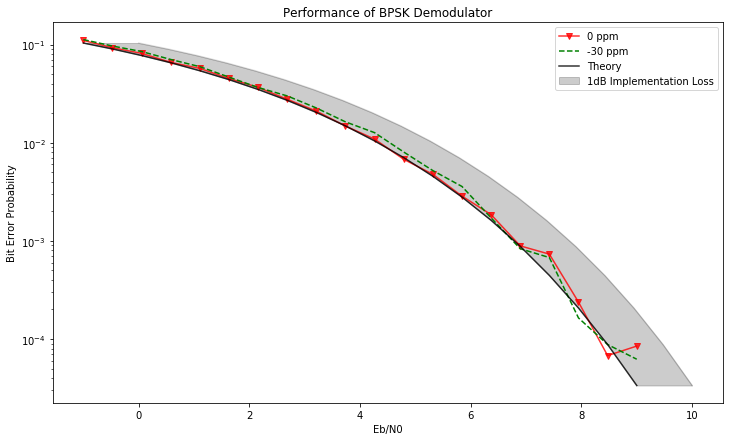

In [4]:
EbN0_lin = 10**(EbN0_dBs/10)
theory = 0.5*erfc(np.sqrt(EbN0_lin))
plt.figure(figsize = (12,7))

plt.fill_betweenx(theory, EbN0_dBs, EbN0_dBs+1, color = "k", alpha = 0.2, label = "1dB Implementation Loss")

plt.semilogy(EbN0_dBs, error_rates[0], 'v-', c = "r", alpha = 0.8, label = f"{clock_drifts[0]} ppm")
plt.semilogy(EbN0_dBs, error_rates[1], '--', c = "green", label = f"{clock_drifts[1]} ppm")
plt.semilogy(EbN0_dBs, theory, '-', c = "k", alpha = 0.8, label = "Theory")
plt.semilogy(EbN0_dBs+1, theory, '-', c = "k", alpha = 0.1)
plt.xlabel("Eb/N0")
plt.ylabel("Bit Error Probability")
plt.title("Performance of BPSK Demodulator")
plt.legend()
plt.show()

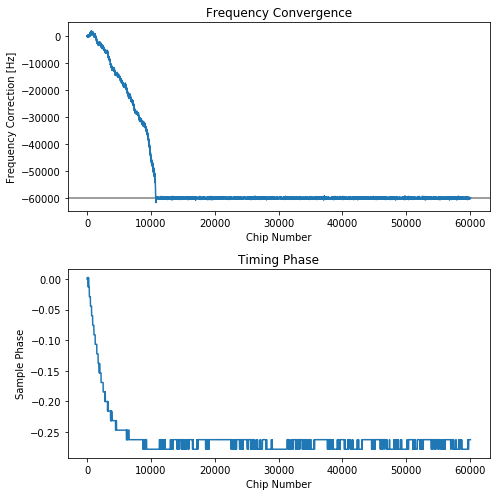

In [5]:
fig, ax = plt.subplots(2,1, figsize = (7, 7))
ax[0].set_title("Frequency Convergence")
ax[0].axhline(drift, c = "k", alpha = .5)
ax[0].plot(freqs)
ax[0].set_xlabel("Chip Number")
ax[0].set_ylabel("Frequency Correction [Hz]")
ax[1].plot(np.unwrap(index%64)/64)
ax[1].set_title("Timing Phase")
ax[1].set_xlabel("Chip Number")
ax[1].set_ylabel("Sample Phase")
fig.tight_layout()
plt.show()